### Setup

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import functools
import einops
import requests
import pandas as pd
import io
import gc
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm import tqdm
from torch import Tensor
from typing import List, Dict, Optional, Tuple
from transformer_lens import HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from jaxtyping import Float, Int
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from huggingface_hub import login as hf_login
import os

from scipy.linalg import svd

/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-12-19 16:21:04.731573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attem

In [3]:
# set HF_TOKEN in .env
token = os.environ.get("HF_TOKEN")
hf_login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
INFERENCE_DTYPE = torch.float16
SEED = 3252

LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"
PEFT_MODEL_PATH_LAT = "nlpett/llama-2-7b-chat-hf-LAT-layer4-hh"
PEFT_MODEL_PATH_AT = "nlpett/llama-2-7b-chat-hf-AT-hh"
print(f"Device: {DEVICE}")

LLAMA_CHAT_TEMPLATE = "\n[INST]{prompt}[/INST]\n"

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output dir: {OUTPUT_DIR.resolve()}")

Device: cuda
Output dir: /home/ubuntu/latent_refusal_geometry/outputs


### Load data & test data

In [5]:
def get_harmful_instructions() -> Tuple[List[str], List[str]]:
    url = 'https://raw.githubusercontent.com/llm-attacks/llm-attacks/main/data/advbench/harmful_behaviors.csv'
    response = requests.get(url)
    dataset = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    instructions = dataset['goal'].tolist()
    train, test = train_test_split(instructions, test_size=0.2, random_state=42)
    return train, test

def get_harmless_instructions() -> Tuple[List[str], List[str]]:
    hf_path = 'tatsu-lab/alpaca'
    dataset = load_dataset(hf_path)
    instructions = [
        dataset['train'][i]['instruction'] 
        for i in range(len(dataset['train']))
        if dataset['train'][i]['input'].strip() == '' # filter instructions wihtout inputs
    ]
    train, test = train_test_split(instructions, test_size=0.2, random_state=42)
    return train, test

harmful_train, harmful_test = get_harmful_instructions()
harmless_train, harmless_test = get_harmless_instructions()

print(f"Harmful instructions: {len(harmful_train)} train, {len(harmful_test)} test")
print(f"Harmless instructions: {len(harmless_train)} train, {len(harmless_test)} test")

Harmful instructions: 416 train, 104 test
Harmless instructions: 25058 train, 6265 test


### Load models & get activations

In [6]:
def load_base_model() -> HookedTransformer:
    base_model = AutoModelForCausalLM.from_pretrained(
        LLAMA_2_7B_CHAT_PATH,
        torch_dtype=INFERENCE_DTYPE,
        device_map="auto",
    )
    
    hooked_model = HookedTransformer.from_pretrained_no_processing(
        LLAMA_2_7B_CHAT_PATH,
        hf_model=base_model,
        dtype=INFERENCE_DTYPE,
        device=DEVICE,
        default_padding_side='left',
    )
    hooked_model.tokenizer.padding_side = 'left'
    hooked_model.tokenizer.pad_token = "[PAD]"
    
    del base_model
    gc.collect()
    torch.cuda.empty_cache()
    
    return hooked_model

def load_peft_model(peft_path: str, model_name: str = "LAT") -> HookedTransformer:
    base_model = AutoModelForCausalLM.from_pretrained(
        LLAMA_2_7B_CHAT_PATH,
        torch_dtype=INFERENCE_DTYPE,
        device_map="auto",
    )

    # merge PEFT adapter    
    peft_model = PeftModel.from_pretrained(base_model, peft_path)
    peft_model = peft_model.to(INFERENCE_DTYPE)
    
    try:
        merged_model = peft_model.merge_and_unload()
        print(f"Merged {model_name} adapter")
    except AttributeError:
        merged_model = peft_model
    
    merged_model.eval()
    
    hooked_model = HookedTransformer.from_pretrained_no_processing(
        LLAMA_2_7B_CHAT_PATH,
        hf_model=merged_model,
        dtype=INFERENCE_DTYPE,
        device=DEVICE,
        default_padding_side='left',
    )
    
    hooked_model.tokenizer.padding_side = 'left'
    hooked_model.tokenizer.pad_token = "[PAD]"
    
    del merged_model, peft_model, base_model
    gc.collect()
    torch.cuda.empty_cache()
    
    return hooked_model

# Load both models into a dictionary
# Can fit both on a 80GB A100 ~14GB each in fp16

models = {}
models['Baseline'] = load_base_model()
models['LAT'] = load_peft_model(PEFT_MODEL_PATH_LAT, "LAT")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Merged LAT adapter
Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [8]:
allocated = torch.cuda.memory_allocated() / 1e9
reserved = torch.cuda.memory_reserved() / 1e9
print(f"\nGPU Memory: {allocated:.1f}GB allocated, {reserved:.1f}GB reserved")


GPU Memory: 28.2GB allocated, 41.4GB reserved


In [9]:
def tokenize_instructions(
    tokenizer: AutoTokenizer,
    instructions: List[str]
) -> Int[Tensor, 'batch_size seq_len']:
    """Tokenize instructions using Llama-2 chat template."""
    prompts = [LLAMA_CHAT_TEMPLATE.format(prompt=instruction) for instruction in instructions]
    return tokenizer(prompts, padding=True, truncation=False, return_tensors="pt").input_ids

def get_activations(
    model: HookedTransformer,
    instructions: List[str],
    layer: int,
    batch_size: int = 32,
    position: int = -1  # Last token by default
) -> torch.Tensor:
    # Get activations at layer n for a given instruction
    # run_with_cache for residual stream activations as we go

    tokenize_fn = functools.partial(tokenize_instructions, tokenizer=model.tokenizer)
    activations = []
    
    for i in tqdm(range(0, len(instructions), batch_size), desc=f"Layer {layer}"):
        batch = instructions[i:i+batch_size]
        toks = tokenize_fn(instructions=batch).to(DEVICE)
        
        with torch.no_grad():
            _, cache = model.run_with_cache( # fw pass and cache intermediate residual stream activations
                toks,
                names_filter=lambda name: f'blocks.{layer}.hook_resid_pre' in name
            )
        activations.append(cache[f'blocks.{layer}.hook_resid_pre'][:, position, :]) 
    
    return torch.cat(activations, dim=0)

def get_activations_all_layers(
    model: HookedTransformer,
    instructions: List[str],
    layers: List[int],
    batch_size: int = 16,
    position: int = -1
) -> Dict[int, torch.Tensor]:
    # Get activations at multiple layers
    tokenize_fn = functools.partial(tokenize_instructions, tokenizer=model.tokenizer)
    activations = {l: [] for l in layers}
    
    for i in tqdm(range(0, len(instructions), batch_size), desc="Extracting activations"):
        batch = instructions[i:i+batch_size]
        toks = tokenize_fn(instructions=batch).to(DEVICE)
        
        with torch.no_grad():
            _, cache = model.run_with_cache(
                toks,
                names_filter=lambda name: 'resid_pre' in name
            )
        
        for l in layers:
            activations[l].append(cache['resid_pre', l][:, position, :])
    
    return {l: torch.cat(acts, dim=0) for l, acts in activations.items()}

### Compute refusal vectors

The difference of mean activations between harmful and harmless prompts. L14 has highest efficacy of refusal direction ablation aross all model variants - see 14.3 in https://arxiv.org/pdf/2504.18872

In [10]:
# global refusal vector computation confiog
N_SAMPLES = 416  # samples to compute vector (matched to previous experiments)
TARGET_LAYER = 14  # target activation layer

harmful_acts = {}   # {model_name: tensor}
harmless_acts = {}  # {model_name: tensor}

for model_name, model in models.items():
    print(f"{model_name} at layer {TARGET_LAYER}:")
    
    harmful_acts[model_name] = get_activations(model, harmful_train[:N_SAMPLES], TARGET_LAYER, batch_size=16)
    harmless_acts[model_name] = get_activations(model, harmless_train[:N_SAMPLES], TARGET_LAYER, batch_size=16)

print(f"shape:", harmful_acts['Baseline'].shape)
refusal_dirs = {}

# old difference of means method, Arditi et al. style refusal direction
# my understanding right now is that this is equivalent to the first right 
# singular vector of the difference matrix - using SVD shows us the larger structure
# so for Gorton et al. metrics (features per dimension, off-diagonal interference) 
# we need basis vectors, computed from (harmful - harmless) activations via SVD

for model_name in models.keys():
    harmful_mean = harmful_acts[model_name].mean(dim=0)
    harmless_mean = harmless_acts[model_name].mean(dim=0)
    
    refusal_dir = harmful_mean - harmless_mean
    refusal_dirs[model_name] = {
        'raw': refusal_dir,
        'normalized': refusal_dir / refusal_dir.norm(),
        'norm': refusal_dir.norm().item()
    }
    print(f"{model_name} refusal direction norm = {refusal_dir.norm().item():.4f}")

# Baseline norm 12.9531
# LAT norm of 28.2188

# what does this mean? 2.2x for LAT 
# the "distance" between the harmless/full clusters?

Baseline at layer 14:


Layer 14: 100%|██████████| 26/26 [00:02<00:00, 12.57it/s]


LAT at layer 14:


Layer 14: 100%|██████████| 26/26 [00:02<00:00, 11.84it/s]

shape: torch.Size([416, 4096])
Baseline refusal direction norm = 12.8594
LAT refusal direction norm = 26.6562


### Analysis of selected layer and refusal vector composition

#### Cosine similarity of baseline and LAT refusal vectors

In [11]:
baseline_dir = harmful_acts['Baseline'].mean(dim=0) - harmless_acts['Baseline'].mean(dim=0)
lat_dir = harmful_acts['LAT'].mean(dim=0) - harmless_acts['LAT'].mean(dim=0)

cos_sim = torch.cosine_similarity(
    (baseline_dir / baseline_dir.norm()).unsqueeze(0),
    (lat_dir / lat_dir.norm()).unsqueeze(0)
).item()

print(f"baseline vs. LAT refusal direction cosine similarity: {cos_sim:.4f}")

baseline vs. LAT refusal direction cosine similarity: 0.0550


#### SVD concentration at layer 14

In [14]:
def explained_variance_ratio(data):
    _, s, _ = svd(data, full_matrices=False)
    variance_ratio = (s**2) / np.sum(s**2)
    return variance_ratio

base_diffs = (harmful_acts['Baseline'] - harmless_acts['Baseline']).cpu().numpy()
lat_diffs = (harmful_acts['LAT'] - harmless_acts['LAT']).cpu().numpy()

base_var = explained_variance_ratio(base_diffs)
lat_var = explained_variance_ratio(lat_diffs)

print(f"Baseline - Top 1: {base_var[0]*100:.1f}%, Top 2: {sum(base_var[:2])*100:.1f}%")
print(f"LAT      - Top 1: {lat_var[0]*100:.1f}%, Top 2: {sum(lat_var[:2])*100:.1f}%")

Baseline - Top 1: 50.5%, Top 2: 54.2%
LAT      - Top 1: 99.2%, Top 2: 99.3%


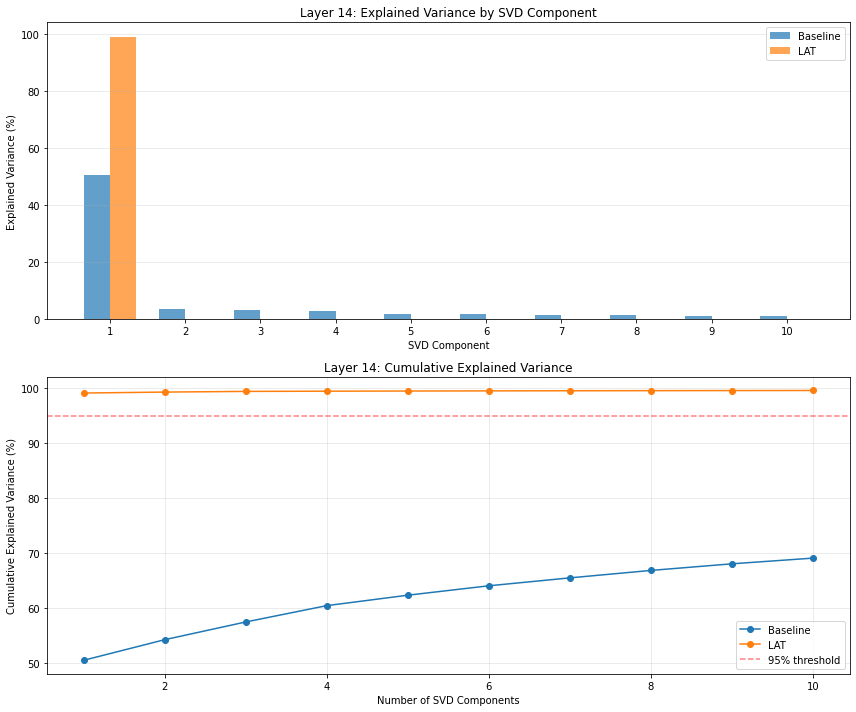


Explained variance at SVD component 1:
Baseline: 0.5050
LAT: 0.9917

Total variance explained by top 10 components:
Baseline: 0.6911
LAT: 0.9963


In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

n_components = 10
x = np.arange(n_components)
width = 0.35

# Bar plot - explained variance per component
ax1.bar(x - width/2, base_var[:n_components] * 100, width, label='Baseline', color='tab:blue', alpha=0.7)
ax1.bar(x + width/2, lat_var[:n_components] * 100, width, label='LAT', color='tab:orange', alpha=0.7)

ax1.set_xlabel('SVD Component')
ax1.set_ylabel('Explained Variance (%)')
ax1.set_title(f'Layer {TARGET_LAYER}: Explained Variance by SVD Component')
ax1.set_xticks(x)
ax1.set_xticklabels(range(1, n_components + 1))
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

base_cum_var = np.cumsum(base_var)
lat_cum_var = np.cumsum(lat_var)

ax2.plot(range(1, n_components+1), base_cum_var[:n_components] * 100, 'o-', color='tab:blue', label='Baseline')
ax2.plot(range(1, n_components+1), lat_cum_var[:n_components] * 100, 'o-', color='tab:orange', label='LAT')
ax2.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% threshold')

ax2.set_xlabel('Number of SVD Components')
ax2.set_ylabel('Cumulative Explained Variance (%)')
ax2.set_title(f'Layer {TARGET_LAYER}: Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'svd_spectrum.png', dpi=150)
plt.show()

# Print summary statistics matching original notebook format
print(f"\nExplained variance at SVD component 1:")
print(f"Baseline: {base_var[0]:.4f}")
print(f"LAT: {lat_var[0]:.4f}")

print(f"\nTotal variance explained by top {n_components} components:")
print(f"Baseline: {sum(base_var[:n_components]):.4f}")
print(f"LAT: {sum(lat_var[:n_components]):.4f}")

---
## Refusal Subspace Analysis


The previous Gram matrix analysis (below) computed interference on per-sample difference vectors (harmful[i] - harmless[i]). This measures consistency of the refusal direction across samples—**not** the feature interference that Gorton (2025) measures.

Gorton's interference metric is computed on the basis vectors spanning the refusal subspace (analogous to W^T W in learned feature representations). For LLMs, the correct approach is to:

1. Compute per-sample difference vectors (harmful - harmless)
2. Extract **basis vectors** via SVD (these are the "features" of refusal)
3. Compute Gram matrix on these basis vectors
4. Extract off-diagonal interference metrics

### from Gorton (2025) & Geometry of Refusal (Wollschläger et al. 2025):

1. **Refusal Subspace Interference (RSI)**: Off-diagonal elements of Gram matrix on refusal basis vectors
2. **Effective Refusal Dimension (ERD)**: Entropy-based measure of how many dimensions encode refusal
3. **Cross-Layer Interference Propagation**: How interference grows across layers

**Hypothesis**: If LAT reduces superposition like adversarial training:
- `mean_off_diagonal_interference` should be **~2× lower** for LAT vs Baseline
- `effective_dimension_entropy` should be **lower** (more concentrated)
- `top_1_sv_ratio` should be **higher** (more variance in first component)

### Metric 1: Refusal Subspace Interference (RSI)

Compute interference in the refusal subspace **basis vectors**, aligned with Gorton's W^T W analysis.

In [ ]:
# we want to compute the feature interference on the basis vectors
# rather than on the refusal direction

N_COMPONENTS = 5  # refusal directions to analyze

rsi_results = {}

for model_name in models.keys():
    print(f"\n{'='*60}")
    print(f"Refusal Subspace Interference: {model_name}")
    print('='*60)
    
    # per sample difference vectors
    diffs = (harmful_acts[model_name] - harmless_acts[model_name]).cpu().float().numpy()
    
    # extract basis via SVD (so all of the features of refusal)
    U, s, Vt = np.linalg.svd(diffs, full_matrices=False)
    basis_vectors = Vt[:N_COMPONENTS]  # Top-k refusal directions (k x d)
    
    # compute Gram matrix on basis vectors (analogous to W^T W)
    gram = basis_vectors @ basis_vectors.T  # k x k
    
    # off-diagonal interference
    n = gram.shape[0]
    mask = ~np.eye(n, dtype=bool)
    off_diag = gram[mask]
    
    mean_interference = np.abs(off_diag).mean()
    max_interference = np.abs(off_diag).max()
    interference_frobenius = np.linalg.norm(gram - np.diag(np.diag(gram)), 'fro')
    
    # 6. Variance concentration (how much is in top-k)
    total_var = (s ** 2).sum()
    top_k_var = (s[:N_COMPONENTS] ** 2).sum()
    concentration = top_k_var / total_var
    
    rsi_results[model_name] = {
        'mean_off_diagonal_interference': mean_interference,
        'max_off_diagonal_interference': max_interference,
        'interference_frobenius_norm': interference_frobenius,
        'variance_concentration_top_k': concentration,
        'singular_values': s[:N_COMPONENTS],
        'gram_matrix': gram
    }
    
    print(f"Mean off-diagonal interference: {mean_interference:.6f}")
    print(f"Max off-diagonal interference: {max_interference:.6f}")
    print(f"Interference Frobenius norm: {interference_frobenius:.6f}")
    print(f"Variance concentration (top {N_COMPONENTS}): {concentration:.4f}")
    print(f"Top {N_COMPONENTS} singular values: {s[:N_COMPONENTS]}")

# Compare models
print(f"\n{'='*60}")
print("COMPARISON: RSI Metrics")
print('='*60)
baseline_rsi = rsi_results['Baseline']['mean_off_diagonal_interference']
lat_rsi = rsi_results['LAT']['mean_off_diagonal_interference']
ratio = baseline_rsi / lat_rsi if lat_rsi > 0 else float('inf')
print(f"Baseline mean interference: {baseline_rsi:.6f}")
print(f"LAT mean interference: {lat_rsi:.6f}")
print(f"Ratio (Baseline/LAT): {ratio:.2f}x")
print(f"\nExpected (from Gorton): ~2x reduction in LAT")

In [ ]:
# Visualize RSI Gram matrices (basis vectors, not per-sample)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, model_name in enumerate(['Baseline', 'LAT']):
    ax = axes[idx]
    gram = rsi_results[model_name]['gram_matrix']
    
    im = ax.imshow(gram, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(f'{model_name}: Refusal Basis Gram Matrix\n(Mean off-diag: {rsi_results[model_name]["mean_off_diagonal_interference"]:.4f})')
    ax.set_xlabel('Basis Vector Index')
    ax.set_ylabel('Basis Vector Index')
    plt.colorbar(im, ax=ax, label='Inner Product')
    
    # Add value annotations
    for i in range(gram.shape[0]):
        for j in range(gram.shape[1]):
            text = ax.text(j, i, f'{gram[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)

plt.suptitle(f'Refusal Subspace Interference (Layer {TARGET_LAYER}): Gram Matrix on Top-{N_COMPONENTS} Basis Vectors', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'rsi_gram_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNote: For orthogonal basis vectors, off-diagonal elements should be 0.")
print("Non-zero off-diagonals indicate interference between refusal directions.")

### Metric 4: Effective Refusal Dimension (ERD)

Compute the effective dimensionality of the refusal subspace using multiple measures:
- **Entropy-based**: exp(H) where H = -Σ p log(p) and p = normalized singular values
- **Threshold-based**: Minimum dimensions to capture 95% variance
- **Participation Ratio**: (Σσ²)² / Σσ⁴

**Hypothesis**: LAT models should have lower effective dimension (more concentrated refusal representation).

In [ ]:
# Metric 4: Effective Refusal Dimension (ERD)
# Compute effective dimensionality of the refusal subspace

VARIANCE_THRESHOLD = 0.95  # Variance to capture

erd_results = {}

for model_name in models.keys():
    print(f"\n{'='*60}")
    print(f"Effective Refusal Dimension: {model_name}")
    print('='*60)
    
    # Get difference vectors
    diffs = (harmful_acts[model_name] - harmless_acts[model_name]).cpu().float().numpy()
    
    # SVD
    _, s, _ = np.linalg.svd(diffs, full_matrices=False)
    
    # Variance explained by each component
    var_explained = (s ** 2) / (s ** 2).sum()
    cumulative_var = np.cumsum(var_explained)
    
    # Effective dimension via entropy: H = -sum(p * log(p))
    p = (s ** 2) / (s ** 2).sum()
    p = p[p > 1e-10]  # Avoid log(0)
    entropy = -np.sum(p * np.log(p))
    effective_dim_entropy = np.exp(entropy)
    
    # Effective dimension via threshold
    effective_dim_threshold = np.searchsorted(cumulative_var, VARIANCE_THRESHOLD) + 1
    
    # Participation ratio: (sum(σ²))² / sum(σ⁴)
    participation_ratio = ((s ** 2).sum() ** 2) / ((s ** 4).sum())
    
    erd_results[model_name] = {
        'effective_dimension_entropy': effective_dim_entropy,
        'effective_dimension_95pct': effective_dim_threshold,
        'participation_ratio': participation_ratio,
        'top_1_variance_ratio': var_explained[0],
        'top_5_variance_ratio': cumulative_var[4] if len(cumulative_var) > 4 else cumulative_var[-1],
        'singular_values': s[:10]
    }
    
    print(f"Effective dim (entropy): {effective_dim_entropy:.2f}")
    print(f"Effective dim (95% var): {effective_dim_threshold}")
    print(f"Participation ratio: {participation_ratio:.2f}")
    print(f"Top-1 variance ratio: {var_explained[0]*100:.1f}%")
    print(f"Top-5 variance ratio: {cumulative_var[4]*100:.1f}%")

# Compare models
print(f"\n{'='*60}")
print("COMPARISON: ERD Metrics")
print('='*60)
print(f"{'Metric':<30} {'Baseline':>15} {'LAT':>15}")
print('-'*60)
for metric in ['effective_dimension_entropy', 'effective_dimension_95pct', 'participation_ratio', 'top_1_variance_ratio']:
    b_val = erd_results['Baseline'][metric]
    l_val = erd_results['LAT'][metric]
    if metric == 'top_1_variance_ratio':
        print(f"{metric:<30} {b_val*100:>14.1f}% {l_val*100:>14.1f}%")
    else:
        print(f"{metric:<30} {b_val:>15.2f} {l_val:>15.2f}")

print(f"\nHypothesis: LAT should have LOWER effective dim and HIGHER top-1 variance ratio")

In [ ]:
# Visualize ERD metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Singular value decay
ax = axes[0]
for model_name in ['Baseline', 'LAT']:
    sv = erd_results[model_name]['singular_values']
    ax.plot(range(1, len(sv)+1), sv, 'o-', label=model_name, markersize=6)
ax.set_xlabel('Component')
ax.set_ylabel('Singular Value')
ax.set_title('Singular Value Decay')
ax.legend()
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Plot 2: Effective dimension comparison
ax = axes[1]
metrics = ['entropy', '95pct', 'participation']
baseline_vals = [
    erd_results['Baseline']['effective_dimension_entropy'],
    erd_results['Baseline']['effective_dimension_95pct'],
    erd_results['Baseline']['participation_ratio']
]
lat_vals = [
    erd_results['LAT']['effective_dimension_entropy'],
    erd_results['LAT']['effective_dimension_95pct'],
    erd_results['LAT']['participation_ratio']
]
x = np.arange(len(metrics))
width = 0.35
ax.bar(x - width/2, baseline_vals, width, label='Baseline', alpha=0.7)
ax.bar(x + width/2, lat_vals, width, label='LAT', alpha=0.7)
ax.set_ylabel('Effective Dimension')
ax.set_title('Effective Dimension Measures')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Cumulative variance explained
ax = axes[2]
for model_name in ['Baseline', 'LAT']:
    diffs = (harmful_acts[model_name] - harmless_acts[model_name]).cpu().float().numpy()
    _, s, _ = np.linalg.svd(diffs, full_matrices=False)
    var_explained = (s ** 2) / (s ** 2).sum()
    cumulative_var = np.cumsum(var_explained)[:20]
    ax.plot(range(1, len(cumulative_var)+1), cumulative_var * 100, 'o-', label=model_name)
ax.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% threshold')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Variance (%)')
ax.set_title('Cumulative Variance Explained')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f'Effective Refusal Dimension Analysis (Layer {TARGET_LAYER})', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'effective_refusal_dimension.png', dpi=150, bbox_inches='tight')
plt.show()

### Metric 2: Cross-Layer Interference Propagation

Measure how refusal interference changes across layers. From Gorton (2025):

> "This vulnerability compounds across layers. At each layer, the adversary can exploit superposition to create unwanted feature activations, which then propagate to the next layer."

**Hypothesis**: LAT models should show slower interference growth across layers.

In [ ]:
# Metric 2: Cross-Layer Interference Propagation
# Track how refusal interference changes across layers

ANALYSIS_LAYERS = [4, 8, 12, 14, 16, 20, 24, 28]  # Layers to analyze
N_SAMPLES_CROSS_LAYER = 50  # Fewer samples for efficiency

cross_layer_results = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Cross-Layer Analysis: {model_name}")
    print('='*60)
    
    # Get activations at multiple layers
    harmful_multi = get_activations_all_layers(model, harmful_train[:N_SAMPLES_CROSS_LAYER], ANALYSIS_LAYERS, batch_size=16)
    harmless_multi = get_activations_all_layers(model, harmless_train[:N_SAMPLES_CROSS_LAYER], ANALYSIS_LAYERS, batch_size=16)
    
    layer_metrics = {}
    for layer in ANALYSIS_LAYERS:
        # Compute difference vectors for this layer
        diffs = (harmful_multi[layer] - harmless_multi[layer]).cpu().float().numpy()
        
        # SVD to get basis vectors
        U, s, Vt = np.linalg.svd(diffs, full_matrices=False)
        basis_vectors = Vt[:N_COMPONENTS]
        
        # Gram matrix on basis vectors
        gram = basis_vectors @ basis_vectors.T
        
        # Off-diagonal interference
        n = gram.shape[0]
        mask = ~np.eye(n, dtype=bool)
        off_diag = gram[mask]
        mean_interference = np.abs(off_diag).mean()
        
        # Effective dimension
        p = (s ** 2) / (s ** 2).sum()
        p = p[p > 1e-10]
        entropy = -np.sum(p * np.log(p))
        effective_dim = np.exp(entropy)
        
        # Variance concentration
        var_explained = (s ** 2) / (s ** 2).sum()
        top_1_var = var_explained[0]
        
        layer_metrics[layer] = {
            'mean_interference': mean_interference,
            'effective_dim': effective_dim,
            'top_1_variance': top_1_var,
            'refusal_norm': np.linalg.norm(diffs.mean(axis=0))
        }
        
        print(f"Layer {layer:2d}: interference={mean_interference:.4f}, eff_dim={effective_dim:.2f}, top1_var={top_1_var*100:.1f}%")
    
    cross_layer_results[model_name] = layer_metrics
    
    # Clean up
    del harmful_multi, harmless_multi
    gc.collect()
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("Cross-Layer Comparison Complete")
print('='*60)

In [ ]:
# Visualize cross-layer interference propagation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean interference across layers
ax = axes[0, 0]
for model_name in ['Baseline', 'LAT']:
    layers = list(cross_layer_results[model_name].keys())
    interference = [cross_layer_results[model_name][l]['mean_interference'] for l in layers]
    ax.plot(layers, interference, 'o-', label=model_name, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Off-Diagonal Interference')
ax.set_title('Interference Propagation Across Layers')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Effective dimension across layers
ax = axes[0, 1]
for model_name in ['Baseline', 'LAT']:
    layers = list(cross_layer_results[model_name].keys())
    eff_dim = [cross_layer_results[model_name][l]['effective_dim'] for l in layers]
    ax.plot(layers, eff_dim, 'o-', label=model_name, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Effective Dimension (entropy)')
ax.set_title('Effective Refusal Dimension Across Layers')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Top-1 variance across layers
ax = axes[1, 0]
for model_name in ['Baseline', 'LAT']:
    layers = list(cross_layer_results[model_name].keys())
    top1_var = [cross_layer_results[model_name][l]['top_1_variance'] * 100 for l in layers]
    ax.plot(layers, top1_var, 'o-', label=model_name, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Top-1 Variance (%)')
ax.set_title('Variance Concentration Across Layers')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Refusal direction norm across layers
ax = axes[1, 1]
for model_name in ['Baseline', 'LAT']:
    layers = list(cross_layer_results[model_name].keys())
    norms = [cross_layer_results[model_name][l]['refusal_norm'] for l in layers]
    ax.plot(layers, norms, 'o-', label=model_name, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Refusal Direction Norm')
ax.set_title('Refusal Direction Magnitude Across Layers')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Cross-Layer Refusal Geometry Analysis', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cross_layer_interference.png', dpi=150, bbox_inches='tight')
plt.show()

# Compute growth rates
print("\nInterference Growth Rates:")
for model_name in ['Baseline', 'LAT']:
    layers = list(cross_layer_results[model_name].keys())
    interference = [cross_layer_results[model_name][l]['mean_interference'] for l in layers]
    growth_rate = np.diff(interference).mean()
    print(f"  {model_name}: {growth_rate:.6f} per layer")

### Metric 3: Representational Independence (Geometry of Refusal)

From Wollschläger et al. (2025):

> "Orthogonality alone does not imply independence under intervention... we introduce representational independence, a criterion for identifying directions that remain mutually unaffected under intervention."

This test checks whether ablating one refusal direction affects the representation of another. If `independence_vs_orthogonality_gap` is large, the model has non-linear dependencies that pure cosine similarity misses.

In [ ]:
# Metric 3: Representational Independence Score
# Test whether ablating one refusal direction affects the representation of another

# Use a subset of test instructions for efficiency
test_instructions = harmful_test[:20] + harmless_test[:20]

rep_ind_results = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Representational Independence: {model_name}")
    print('='*60)
    
    # Get refusal subspace basis vectors (top 2 for this test)
    diffs = (harmful_acts[model_name] - harmless_acts[model_name]).cpu().float()
    U, s, Vt = torch.linalg.svd(diffs, full_matrices=False)
    
    direction_1 = Vt[0].to(DEVICE).to(INFERENCE_DTYPE)  # First refusal direction
    direction_2 = Vt[1].to(DEVICE).to(INFERENCE_DTYPE)  # Second refusal direction
    
    # Normalize directions
    direction_1 = direction_1 / direction_1.norm()
    direction_2 = direction_2 / direction_2.norm()
    
    # Geometric orthogonality (cosine similarity)
    cosine_sim = torch.cosine_similarity(direction_1.unsqueeze(0), direction_2.unsqueeze(0)).item()
    geometric_orthogonality = 1 - abs(cosine_sim)
    
    # Get baseline activations
    baseline_acts = get_activations(model, test_instructions, TARGET_LAYER, batch_size=16)
    baseline_proj_1 = (baseline_acts @ direction_1).cpu()
    baseline_proj_2 = (baseline_acts @ direction_2).cpu()
    
    # Ablate direction_1 and measure effect on direction_2's representation
    # Using TransformerLens hook
    def directional_ablation_hook(resid, hook):
        # Remove component along direction_1 from residual stream
        proj = (resid @ direction_1).unsqueeze(-1) * direction_1
        return resid - proj
    
    model.reset_hooks()
    model.add_hook(f'blocks.{TARGET_LAYER}.hook_resid_pre', directional_ablation_hook)
    
    ablated_acts = get_activations(model, test_instructions, TARGET_LAYER, batch_size=16)
    ablated_proj_2 = (ablated_acts @ direction_2).cpu()
    model.reset_hooks()
    
    # Compute independence score
    proj_change = (ablated_proj_2 - baseline_proj_2).abs().mean().item()
    baseline_magnitude = baseline_proj_2.abs().mean().item()
    independence_score = 1.0 - (proj_change / max(baseline_magnitude, 1e-10))
    independence_score = max(0, min(1, independence_score))  # Clamp to [0, 1]
    
    # Gap between geometric orthogonality and representational independence
    independence_gap = independence_score - geometric_orthogonality
    
    rep_ind_results[model_name] = {
        'geometric_orthogonality': geometric_orthogonality,
        'representational_independence_score': independence_score,
        'ablation_effect_magnitude': proj_change,
        'independence_vs_orthogonality_gap': independence_gap
    }
    
    print(f"Geometric orthogonality (1 - |cos_sim|): {geometric_orthogonality:.4f}")
    print(f"Representational independence score: {independence_score:.4f}")
    print(f"Ablation effect magnitude: {proj_change:.4f}")
    print(f"Independence vs orthogonality gap: {independence_gap:.4f}")
    print(f"\nNote: Large gap indicates non-linear dependencies not captured by cosine similarity")

# Compare models
print(f"\n{'='*60}")
print("COMPARISON: Representational Independence")
print('='*60)
print(f"{'Metric':<40} {'Baseline':>15} {'LAT':>15}")
print('-'*70)
for metric in ['geometric_orthogonality', 'representational_independence_score', 'independence_vs_orthogonality_gap']:
    b_val = rep_ind_results['Baseline'][metric]
    l_val = rep_ind_results['LAT'][metric]
    print(f"{metric:<40} {b_val:>15.4f} {l_val:>15.4f}")

---
## Summary: Expected vs Observed Results

### Gorton's Hypothesis Applied to LAT

If LAT operates analogously to adversarial training in reducing superposition, we expect:

| Metric | Expected Direction | Gorton's Finding |
|--------|-------------------|------------------|
| mean_off_diagonal_interference | LAT < Baseline | ~2× reduction |
| effective_dimension_entropy | LAT < Baseline | Lower = more concentrated |
| top_1_sv_ratio | LAT > Baseline | Higher = simpler structure |
| interference_growth_rate | LAT < Baseline | Slower propagation |

In [ ]:
# Final Summary: Expected vs Observed Results
import pandas as pd

print("="*80)
print("FINAL SUMMARY: LAT vs Baseline Refusal Geometry (Layer 14)")
print("="*80)

# Build summary dataframe
summary_data = []

# RSI metrics
summary_data.append({
    'Metric': 'mean_off_diagonal_interference',
    'Baseline': rsi_results['Baseline']['mean_off_diagonal_interference'],
    'LAT': rsi_results['LAT']['mean_off_diagonal_interference'],
    'Expected': 'LAT < Baseline (~2×)',
    'Ratio (B/L)': rsi_results['Baseline']['mean_off_diagonal_interference'] / max(rsi_results['LAT']['mean_off_diagonal_interference'], 1e-10)
})

summary_data.append({
    'Metric': 'interference_frobenius_norm',
    'Baseline': rsi_results['Baseline']['interference_frobenius_norm'],
    'LAT': rsi_results['LAT']['interference_frobenius_norm'],
    'Expected': 'LAT < Baseline',
    'Ratio (B/L)': rsi_results['Baseline']['interference_frobenius_norm'] / max(rsi_results['LAT']['interference_frobenius_norm'], 1e-10)
})

# ERD metrics
summary_data.append({
    'Metric': 'effective_dimension_entropy',
    'Baseline': erd_results['Baseline']['effective_dimension_entropy'],
    'LAT': erd_results['LAT']['effective_dimension_entropy'],
    'Expected': 'LAT < Baseline',
    'Ratio (B/L)': erd_results['Baseline']['effective_dimension_entropy'] / max(erd_results['LAT']['effective_dimension_entropy'], 1e-10)
})

summary_data.append({
    'Metric': 'top_1_variance_ratio',
    'Baseline': erd_results['Baseline']['top_1_variance_ratio'],
    'LAT': erd_results['LAT']['top_1_variance_ratio'],
    'Expected': 'LAT > Baseline',
    'Ratio (B/L)': erd_results['Baseline']['top_1_variance_ratio'] / max(erd_results['LAT']['top_1_variance_ratio'], 1e-10)
})

summary_data.append({
    'Metric': 'variance_concentration_top5',
    'Baseline': rsi_results['Baseline']['variance_concentration_top_k'],
    'LAT': rsi_results['LAT']['variance_concentration_top_k'],
    'Expected': 'LAT > Baseline',
    'Ratio (B/L)': rsi_results['Baseline']['variance_concentration_top_k'] / max(rsi_results['LAT']['variance_concentration_top_k'], 1e-10)
})

# Cross-layer growth rate
baseline_interference = [cross_layer_results['Baseline'][l]['mean_interference'] for l in ANALYSIS_LAYERS]
lat_interference = [cross_layer_results['LAT'][l]['mean_interference'] for l in ANALYSIS_LAYERS]
baseline_growth = np.diff(baseline_interference).mean()
lat_growth = np.diff(lat_interference).mean()

summary_data.append({
    'Metric': 'interference_growth_rate',
    'Baseline': baseline_growth,
    'LAT': lat_growth,
    'Expected': 'LAT < Baseline',
    'Ratio (B/L)': baseline_growth / max(lat_growth, 1e-10) if lat_growth != 0 else float('inf')
})

# Representational independence
summary_data.append({
    'Metric': 'representational_independence',
    'Baseline': rep_ind_results['Baseline']['representational_independence_score'],
    'LAT': rep_ind_results['LAT']['representational_independence_score'],
    'Expected': 'LAT > Baseline',
    'Ratio (B/L)': rep_ind_results['Baseline']['representational_independence_score'] / max(rep_ind_results['LAT']['representational_independence_score'], 1e-10)
})

# Display summary
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

# Check each hypothesis
hypotheses_met = 0
total_hypotheses = 0

# 1. Interference should be lower in LAT
total_hypotheses += 1
if rsi_results['LAT']['mean_off_diagonal_interference'] < rsi_results['Baseline']['mean_off_diagonal_interference']:
    hypotheses_met += 1
    print("✓ Mean off-diagonal interference is LOWER in LAT (supports Gorton hypothesis)")
else:
    print("✗ Mean off-diagonal interference is HIGHER in LAT (contradicts Gorton hypothesis)")

# 2. Effective dimension should be lower in LAT
total_hypotheses += 1
if erd_results['LAT']['effective_dimension_entropy'] < erd_results['Baseline']['effective_dimension_entropy']:
    hypotheses_met += 1
    print("✓ Effective dimension is LOWER in LAT (more concentrated representation)")
else:
    print("✗ Effective dimension is HIGHER in LAT (less concentrated)")

# 3. Top-1 variance should be higher in LAT
total_hypotheses += 1
if erd_results['LAT']['top_1_variance_ratio'] > erd_results['Baseline']['top_1_variance_ratio']:
    hypotheses_met += 1
    print("✓ Top-1 variance ratio is HIGHER in LAT (simpler structure)")
else:
    print("✗ Top-1 variance ratio is LOWER in LAT")

# 4. Growth rate should be lower in LAT
total_hypotheses += 1
if lat_growth < baseline_growth:
    hypotheses_met += 1
    print("✓ Interference growth rate is LOWER in LAT (slower propagation)")
else:
    print("✗ Interference growth rate is HIGHER in LAT")

# 5. Representational independence should be higher in LAT
total_hypotheses += 1
if rep_ind_results['LAT']['representational_independence_score'] > rep_ind_results['Baseline']['representational_independence_score']:
    hypotheses_met += 1
    print("✓ Representational independence is HIGHER in LAT")
else:
    print("✗ Representational independence is LOWER in LAT")

print(f"\nHypotheses supported: {hypotheses_met}/{total_hypotheses}")
print("\nConclusion: ", end="")
if hypotheses_met >= 4:
    print("Strong evidence that LAT reduces superposition similarly to adversarial training")
elif hypotheses_met >= 2:
    print("Partial evidence for LAT reducing superposition")
else:
    print("Limited/no evidence for LAT operating like adversarial training in this framework")

---
## IGNORE FOR NOW: GRAM MATRIX AND INTERFERENCE ANALYSIS
The Gram matrix G = D @ D^T captures pairwise similarities between difference directions. Off-diagonal elements measure "interference" - how much different prompts' refusal directions overlap.

**Key metrics:**
- Mean off-diagonal: Average |G_ij| for i ≠ j (lower = less interference)
- Interference Frobenius: ||G - diag(G)||_F (total interference magnitude)

In [ ]:
def compute_gram_matrix(directions: torch.Tensor, normalize: bool = True) -> torch.Tensor:
    """
    Compute Gram matrix G = D @ D^T
    If normalize=True, computes cosine similarity matrix instead.
    """
    if normalize:
        norms = directions.norm(dim=1, keepdim=True)
        norms = torch.clamp(norms, min=1e-8)
        directions_normed = directions / norms
        gram = directions_normed @ directions_normed.T
    else:
        gram = directions @ directions.T
    return gram


def compute_interference_metrics(gram: torch.Tensor) -> dict:
    """
    Compute interference metrics from Gram matrix.
    """
    n = gram.shape[0]
    
    # Extract off-diagonal elements
    mask = ~torch.eye(n, dtype=torch.bool, device=gram.device)
    off_diag = gram[mask]
    
    # Mean off-diagonal magnitude
    mean_off_diagonal = off_diag.abs().mean().item()
    
    # Interference Frobenius norm: ||G - diag(G)||_F
    diag_matrix = torch.diag(torch.diag(gram))
    interference_frobenius = (gram - diag_matrix).norm('fro').item()
    
    # Standard deviation of off-diagonal
    off_diagonal_std = off_diag.std().item()
    
    return {
        'mean_off_diagonal': mean_off_diagonal,
        'interference_frobenius': interference_frobenius,
        'off_diagonal_std': off_diagonal_std,
        'off_diagonal_values': off_diag.cpu().numpy()
    }

In [ ]:
# Compute Gram matrix and interference for BOTH models at layer 14
interference_results = {}

for model_name in models.keys():
    # Compute difference directions
    directions = compute_difference_directions(harmful_acts[model_name], harmless_acts[model_name])
    
    # Compute normalized Gram matrix (cosine similarities)
    gram = compute_gram_matrix(directions, normalize=True)
    
    # Compute interference metrics
    interference = compute_interference_metrics(gram)
    interference['gram'] = gram
    interference['directions'] = directions
    interference_results[model_name] = interference

# Print comparison
print("="*60)
print(f"Interference Metrics at Layer {TARGET_LAYER}")
print("="*60)
print(f"{'Metric':<30} {'Baseline':<15} {'LAT':<15}")
print("-"*60)
for metric in ['mean_off_diagonal', 'interference_frobenius', 'off_diagonal_std']:
    base = interference_results['Baseline'][metric]
    lat = interference_results['LAT'][metric]
    print(f"{metric:<30} {base:<15.4f} {lat:<15.4f}")

In [ ]:
# Visualize Gram matrices for BOTH models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, model_name in enumerate(models.keys()):
    gram = interference_results[model_name]['gram']
    off_diag = interference_results[model_name]['off_diagonal_values']
    
    # Gram matrix heatmap
    im = axes[idx, 0].imshow(gram.cpu().numpy(), cmap='RdBu_r', vmin=-1, vmax=1)
    axes[idx, 0].set_title(f'{model_name}: Cosine Similarity Matrix', fontsize=12)
    axes[idx, 0].set_xlabel('Prompt Pair Index')
    axes[idx, 0].set_ylabel('Prompt Pair Index')
    plt.colorbar(im, ax=axes[idx, 0], label='Cosine Similarity')
    
    # Histogram of off-diagonal values
    axes[idx, 1].hist(off_diag, bins=50, edgecolor='black', alpha=0.7, 
                      color='blue' if model_name == 'Baseline' else 'orange')
    axes[idx, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
    axes[idx, 1].axvline(x=off_diag.mean(), color='green', linestyle='--', linewidth=2, 
                         label=f'Mean: {off_diag.mean():.3f}')
    mean_abs = interference_results[model_name]['mean_off_diagonal']
    axes[idx, 1].set_title(f'{model_name}: Off-Diagonal Distribution\nMean |sim|: {mean_abs:.3f}', fontsize=12)
    axes[idx, 1].set_xlabel('Cosine Similarity')
    axes[idx, 1].set_ylabel('Count')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f'gram_matrix_layer{TARGET_LAYER}_comparison.png', dpi=150)
plt.show()